<div style='background-color:#f7f7f7; padding-top:30px; padding-left:20px; padding-right:20px; padding-bottom:30px'>
    <center>
        <div style='  display: block;
  font-size: 2em;
  font-weight: bold;  display: block;
  font-size: 2em;
  font-weight: bold;'>The Bayesian Blocks Algorithm
        </div>
    <center>
        <br>
    <i>Gabriele Bertinelli - Matteo Lovato</i></center>
    <i>2103359 - *******</i>
    <center>

### 0. Packages and Options

In [3]:
library(tidyverse)
library(microbenchmark)
library(latex2exp)
library(gridExtra)
library(gganimate)
library(gifski)

source('../scripts/func_bb.R')

set.seed(9725)

options(warn=-1)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Caricamento pacchetto: 'gridExtra'


Il seguente oggetto è mascherato da 'package:dplyr':

    combine




## 1. Benchmark

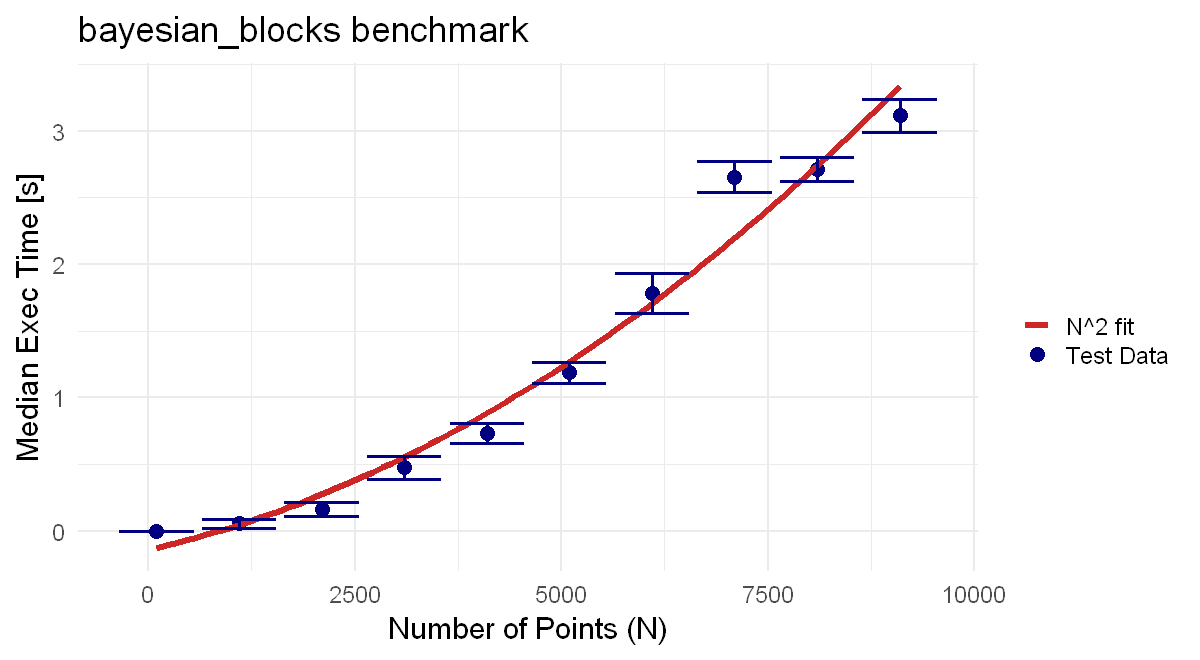

In [7]:
res_df <- read.csv('../data/benchmark_bb_func.csv')

res_df <- res_df[seq(1, 1000, by=10), ]

options(repr.plot.width = 10, repr.plot.height = 5.5)

bench_plot <- ggplot(res_df, aes(x=x, y=y)) + 
                       geom_point(aes(color='Test Data'), size=4) +
                       stat_smooth(method = "lm", formula = y ~ poly(x, 2), se = FALSE, aes(color = 'N^2 fit'), linewidth=1.7) + 
                       labs(x = 'Number of Points (N)', y = 'Median Exec Time [s]', title = 'bayesian_blocks benchmark', color='') +
                       scale_color_manual(values = c('Test Data' = 'navy', 'N^2 fit' = 'firebrick3')) +
                       theme_minimal(base_size = 18) + 
                       geom_errorbar(aes(ymin=lower, ymax=upper), linewidth = 1, color='navy')
bench_plot

In [ ]:
ggsave('../images/benchmark_plot.png', plot=bench_plot, width = 10, height = 5.5)

## 2. Applications

### 2.1. Mix of Normal Distributed Variables

In [10]:
norm_data <- c(rnorm(5000,-3,0.7),rnorm(3000,0,0.3),rnorm(5000,2.5,1))
N <- length(norm_data)

cat(sqrt(N))

114.0175

In [19]:
# gamma prior

breaks_gamma <- bayesian_blocks(norm_data, gamma=0.001)

# p0 prior

breaks_p0 <- bayesian_blocks(norm_data, p0=0.05)

N_edges_gamma <- length(breaks_gamma)
N_edges_p0 <- length(breaks_p0)
cat('N° of gamma breaks = ', N_edges_gamma, "\n")
cat('N° of p0 breaks = ', N_edges_p0)

N° of gamma breaks =  30 
N° of p0 breaks =  29

In [20]:
counts <- rep(1, 13000)
x_lin <- seq(0, 100, length.out = 10000)

density <- dnorm(x_lin, mean=-3, sd=0.7) + dnorm(x_lin, mean=0, sd=3) + dnorm(x_lin, mean=2.5, sd=1)
density <- density/sum(density*0.01)

steps_gamma <- rep(0, N_edges_gamma)
steps_p0 <- rep(0, N_edges_p0)

for (K in seq(1: N_edges_gamma)){    
    steps_gamma[K] = sum(counts[norm_data>=breaks_gamma[K] 
                                & norm_data<breaks_gamma[K+1]])/sum(counts*(breaks_gamma[K+1] - breaks_gamma[K]))    
    if (K==N_edges_gamma-1){break}
}

steps_gamma[N_edges_gamma] = steps_gamma[N_edges_gamma-1]

for (K in seq(1: N_edges_p0)){    
    steps_p0[K] = sum(counts[norm_data>=breaks_p0[K] 
                                & norm_data<breaks_p0[K+1]])/sum(counts*(breaks_p0[K+1] - breaks_p0[K]))    
    if (K==N_edges_p0-1){break}
}

steps_p0[N_edges_p0] = steps_p0[N_edges_p0-1]

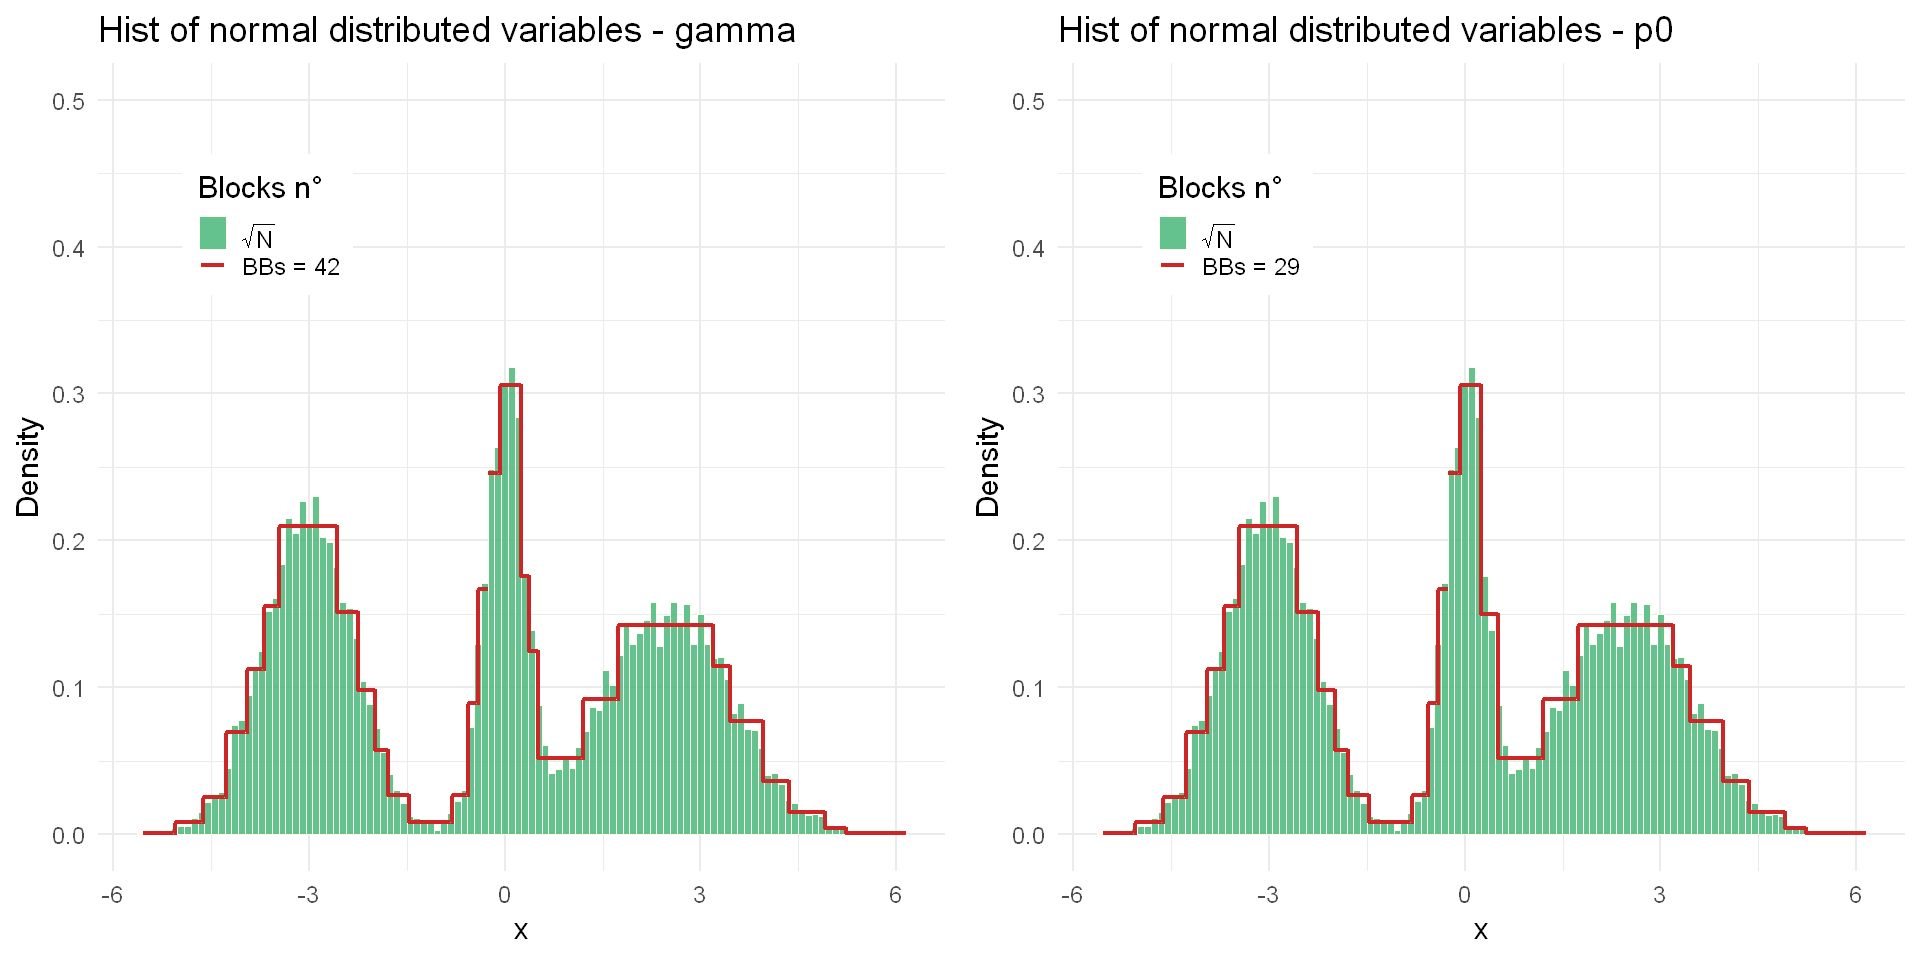

In [21]:
options(repr.plot.width=16, repr.plot.height=8)

layout <- matrix(c(1,2), ncol=2, byrow=T)

hist_gamma <- ggplot() + 
    geom_histogram(aes(x=norm_data, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), bins = floor(sqrt(N)), alpha = 0.8) +
    geom_step(aes(x=breaks_gamma, y=steps_gamma, color=as.factor(2), fill=as.factor(2)), linewidth=1.2) + 
    theme_minimal(base_size = 18) + 
    theme(legend.position = c(0.2, 0.8), legend.background = element_rect(fill = "white", color='white')) +
    scale_fill_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'), 'BBs = 42'), 
                      values = c('mediumseagreen', 'firebrick3')) + 
    scale_colour_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'),'BBs = 42'),
                       values = c('ivory', 'firebrick3'))+
    labs(x='x', y='Density', title='Hist of normal distributed variables - gamma') +
    ylim(c(0,.5))

hist_p0 <- ggplot() + 
    geom_histogram(aes(x=norm_data, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), bins = floor(sqrt(N)), alpha = 0.8) +
    geom_step(aes(x=breaks_p0, y=steps_p0, color=as.factor(2), fill=as.factor(2)), linewidth=1.2) + 
    theme_minimal(base_size = 18) + 
    theme(legend.position = c(0.2, 0.8), legend.background = element_rect(fill = "white", color='white')) +
    scale_fill_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'), 'BBs = 29'), 
                      values = c('mediumseagreen', 'firebrick3')) + 
    scale_colour_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'),'BBs = 29'),
                       values = c('ivory', 'firebrick3'))+ 
    labs(x='x', y='Density', title='Hist of normal distributed variables - p0') + 
    ylim(c(0,.5))

mix_plot <- grid.arrange(hist_gamma, hist_p0, layout_matrix = layout)

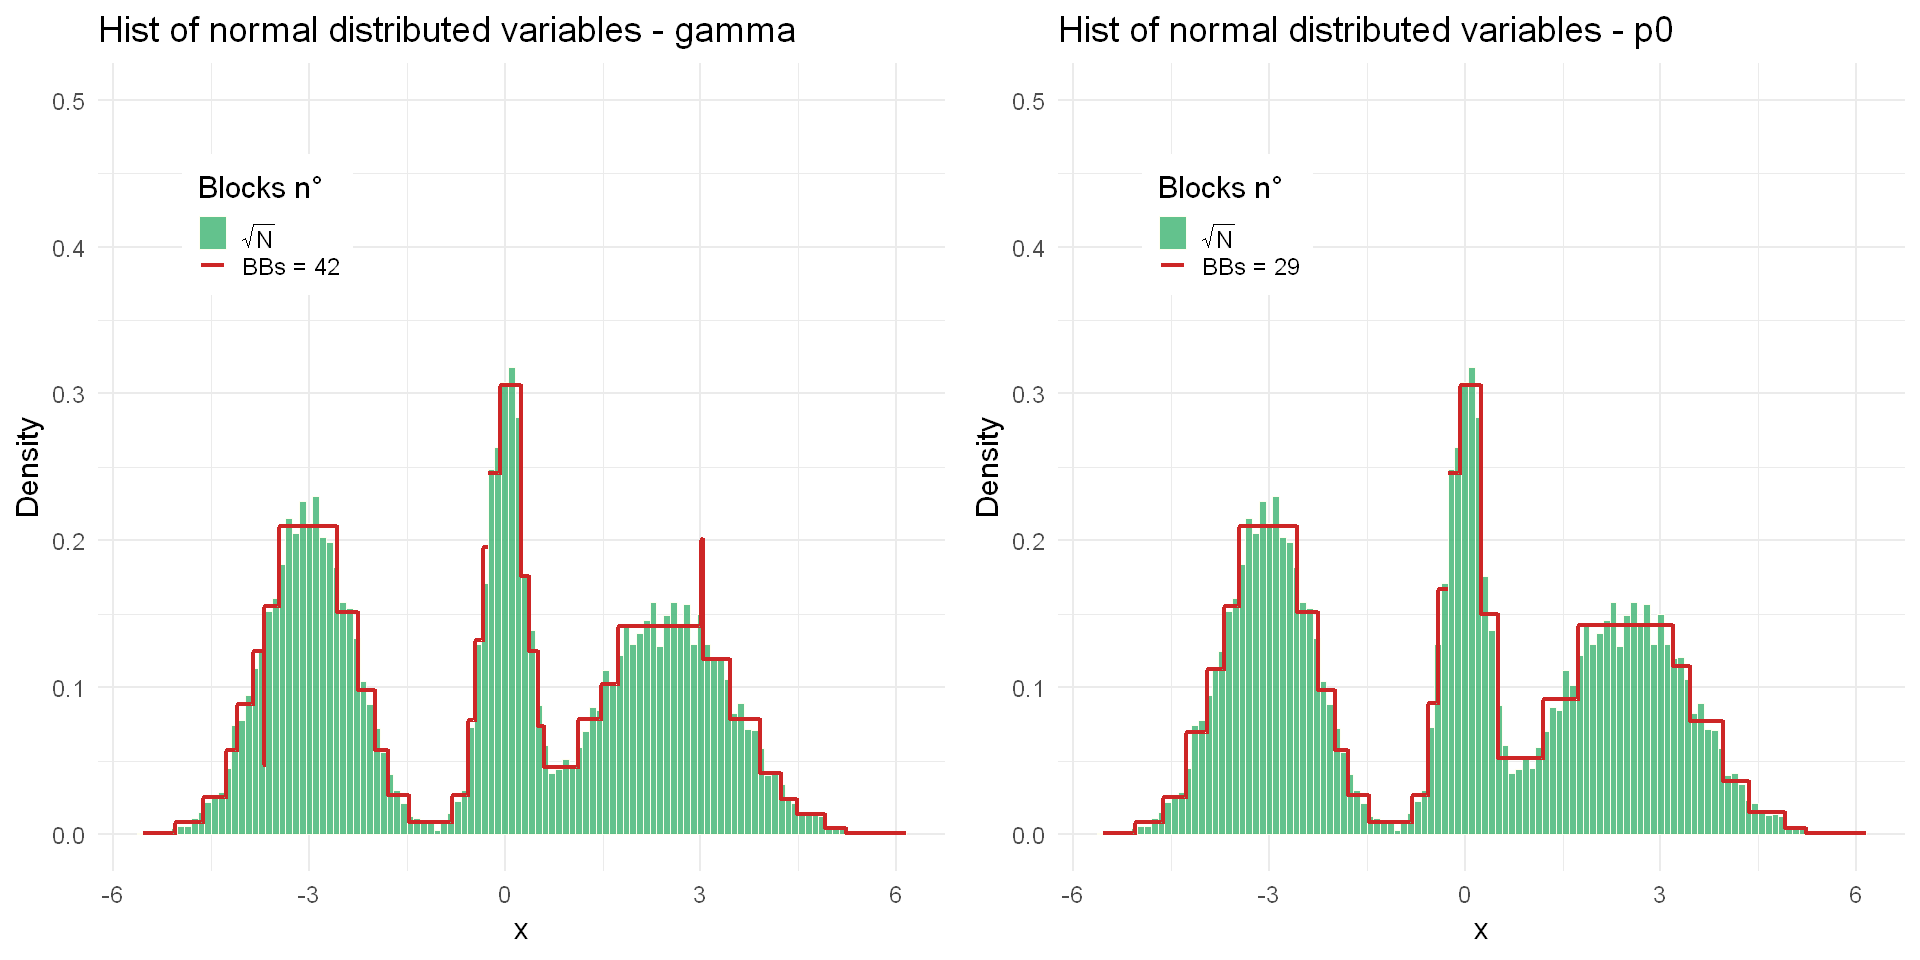

In [15]:
ggsave('../images/test_mix_normal.png', plot=mix_plot, width = 16, height = 8)

### 2.2. Uniform Background and Gaussian Signals

In [22]:
noise <- runif(1e4,0,8)
signal_1 <- rnorm(1e3,3,0.9)
signal_2 <- rnorm(1e3,7,0.3)
signal_3 <- rnorm(1e3,5,0.07)

tot_sig <- c(noise, signal_1, signal_2, signal_3)

N <- length(tot_sig)

cat(sqrt(N))

114.0175

In [23]:
breaks_noise_gamma <- bayesian_blocks(tot_sig, gamma=0.001)

breaks_noise_p0 <- bayesian_blocks(tot_sig, p0=0.05)

N_edges_noise_g <- length(breaks_noise_gamma)
N_edges_noise_p0 <- length(breaks_noise_p0)
cat('N° of gamma breaks =', N_edges_noise_g, '\n')
cat('N° of p0 breaks =', N_edges_noise_p0, '\n')

N° of gamma breaks = 12 
N° of p0 breaks = 12 


In [24]:
counts <- rep(1, 13000)
x_lin <- seq(0, 100, length.out = 10000)

density <- dunif(x_lin, min=0, max=8) + 
            dnorm(x_lin, mean=3, sd=0.9) + 
            dnorm(x_lin, mean=7, sd=0.3) + 
            dnorm(x_lin, mean=5, sd=0.7)
density <- density/sum(density*0.01)

steps_noise_g <- rep(0, N_edges_noise_g)
steps_noise_p0 <- rep(0, N_edges_noise_p0)

for (K in seq(1: N_edges_noise_g)){    
    steps_noise_g[K] = sum(counts[tot_sig>=breaks_noise_gamma[K] 
                                & tot_sig<breaks_noise_gamma[K+1]])/sum(counts*(breaks_noise_gamma[K+1] - breaks_noise_gamma[K]))    
    if (K==N_edges_noise_g-1){break}
}

steps_noise_g[N_edges_noise_g] = steps_noise_g[N_edges_noise_g-1]

for (K in seq(1: N_edges_noise_p0)){    
    steps_noise_p0[K] = sum(counts[tot_sig>=breaks_noise_p0[K] 
                                & tot_sig<breaks_noise_p0[K+1]])/sum(counts*(breaks_noise_p0[K+1] - breaks_noise_p0[K]))    
    if (K==N_edges_noise_p0-1){break}
}

steps_noise_p0[N_edges_noise_p0] = steps_noise_p0[N_edges_noise_p0-1]

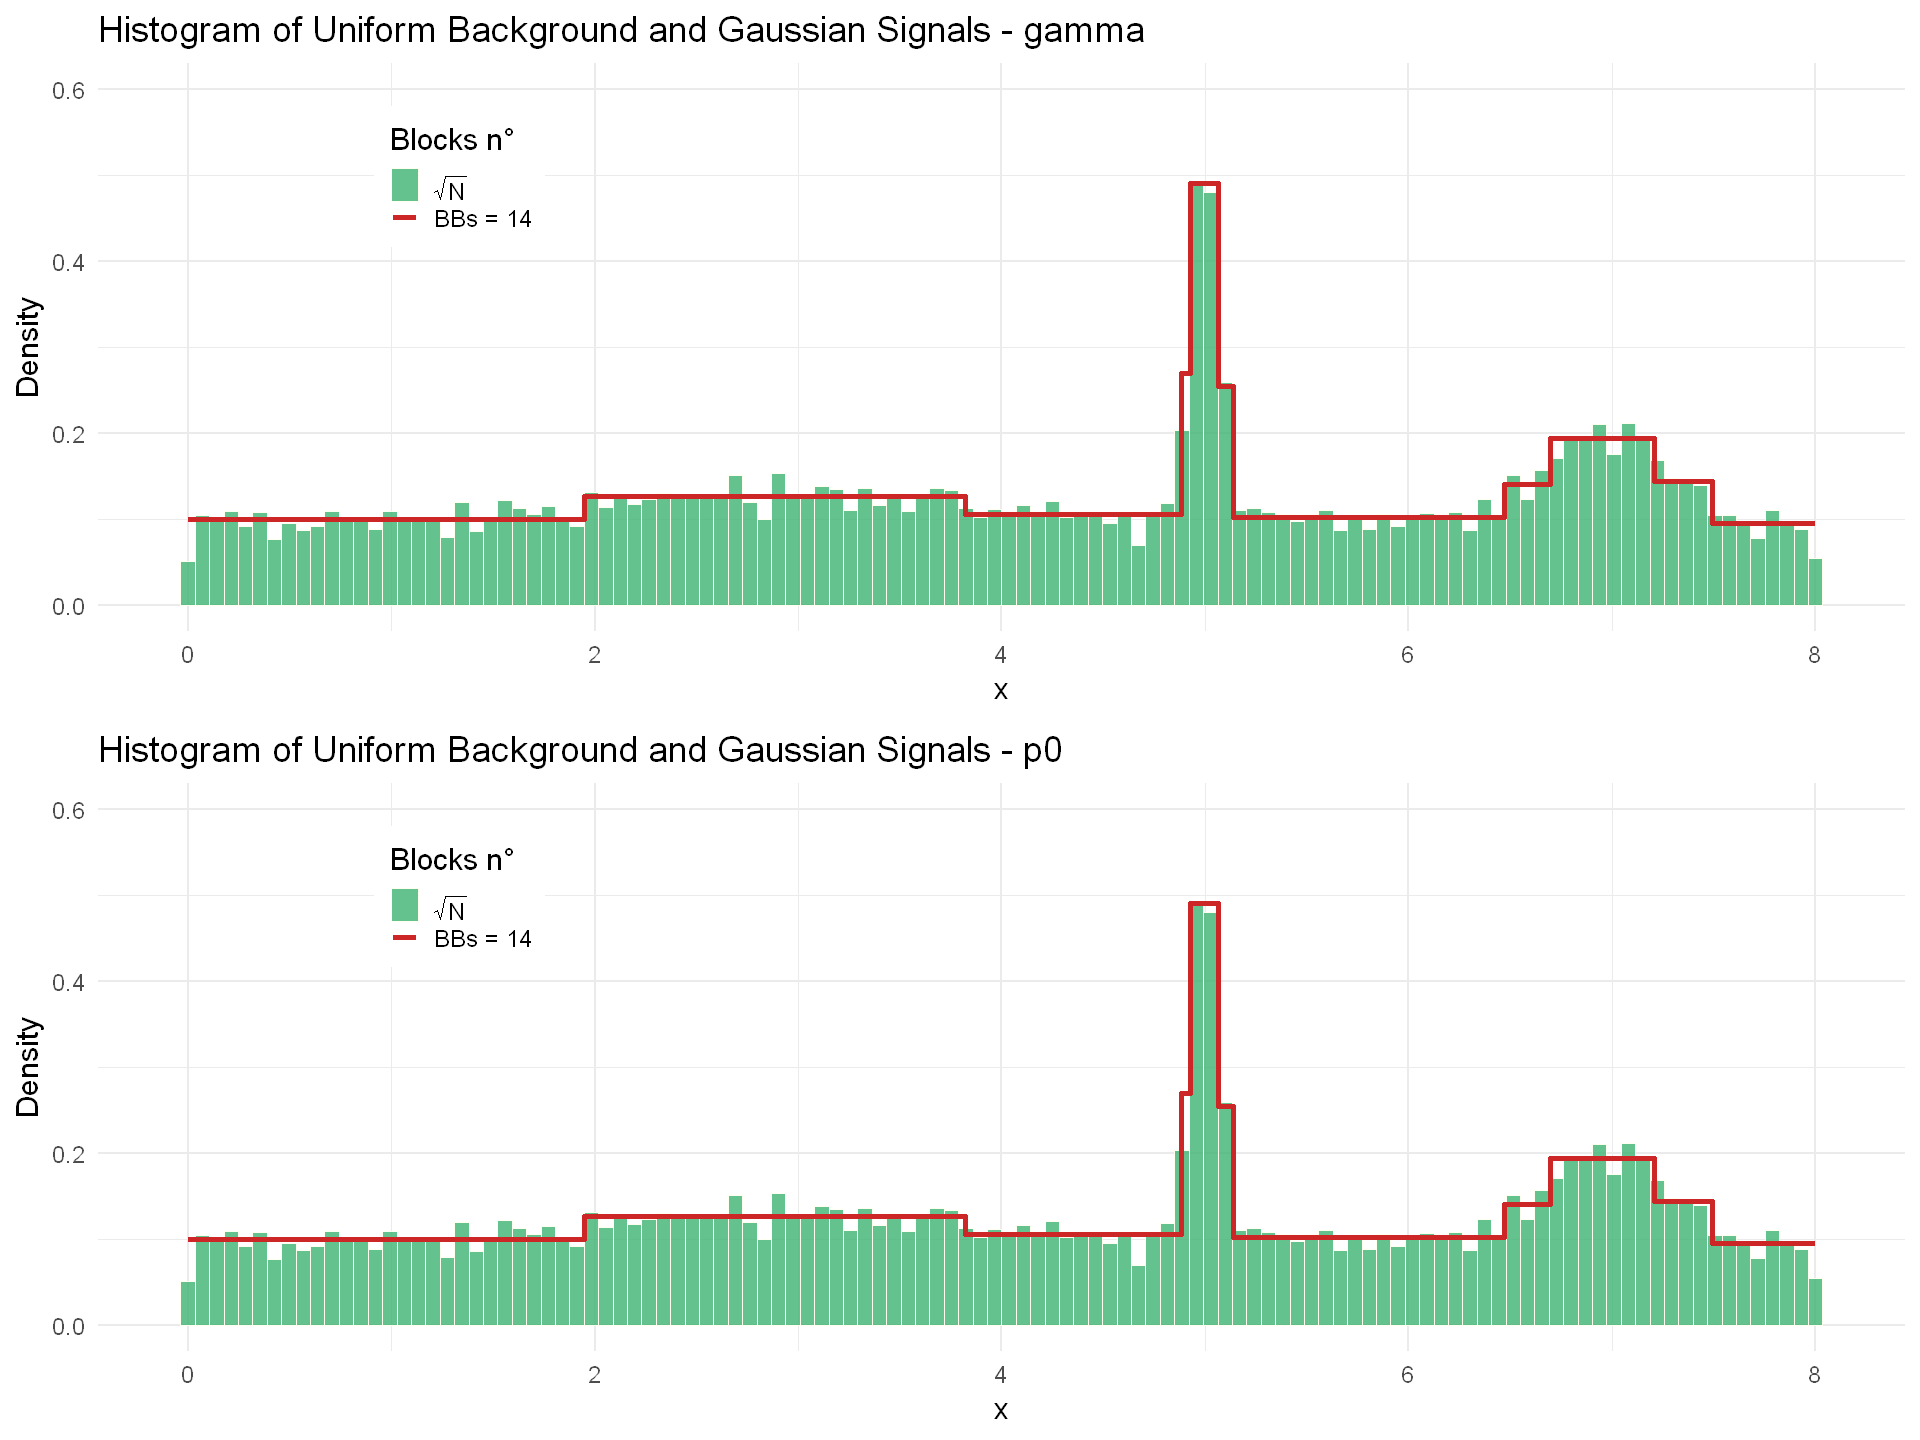

In [25]:
options(repr.plot.width=16, repr.plot.height=12)

layout <- matrix(c(1,2,1,2), ncol=2, byrow=F)

hist_noise_gamma <- ggplot() + 
    geom_histogram(aes(x=tot_sig, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), bins = floor(sqrt(N)), alpha = 0.8) +
    geom_step(aes(x=breaks_noise_gamma, y=steps_noise_g, color=as.factor(2), fill=as.factor(2)), linewidth=1.6) + 
    theme_minimal(base_size = 18) + 
    theme(legend.position = c(0.2, 0.8), legend.background = element_rect(fill = "white", color='white')) +
    scale_fill_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'), 'BBs = 14'), 
                      values = c('mediumseagreen', 'firebrick3')) + 
    scale_colour_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'),'BBs = 14'),
                       values = c('ivory', 'firebrick3'))+
    labs(x='x', y='Density', title='Histogram of Uniform Background and Gaussian Signals - gamma') +
    ylim(c(0,.6))

hist_noise_p0 <- ggplot() + 
    geom_histogram(aes(x=tot_sig, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), bins = floor(sqrt(N)), alpha = 0.8) +
    geom_step(aes(x=breaks_noise_p0, y=steps_noise_p0, color=as.factor(2), fill=as.factor(2)), linewidth=1.6) + 
    theme_minimal(base_size = 18) + 
    theme(legend.position = c(0.2, 0.8), legend.background = element_rect(fill = "white", color='white')) +
    scale_fill_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'), 'BBs = 14'), 
                      values = c('mediumseagreen', 'firebrick3')) + 
    scale_colour_manual(name = 'Blocks n°', labels = c(TeX(r'($\sqrt{N}$)'),'BBs = 14'),
                       values = c('ivory', 'firebrick3'))+
    labs(x='x', y='Density', title='Histogram of Uniform Background and Gaussian Signals - p0') + 
    ylim(c(0,.6))

noise_plot <- grid.arrange(hist_noise_gamma, hist_noise_p0, layout_matrix = layout)

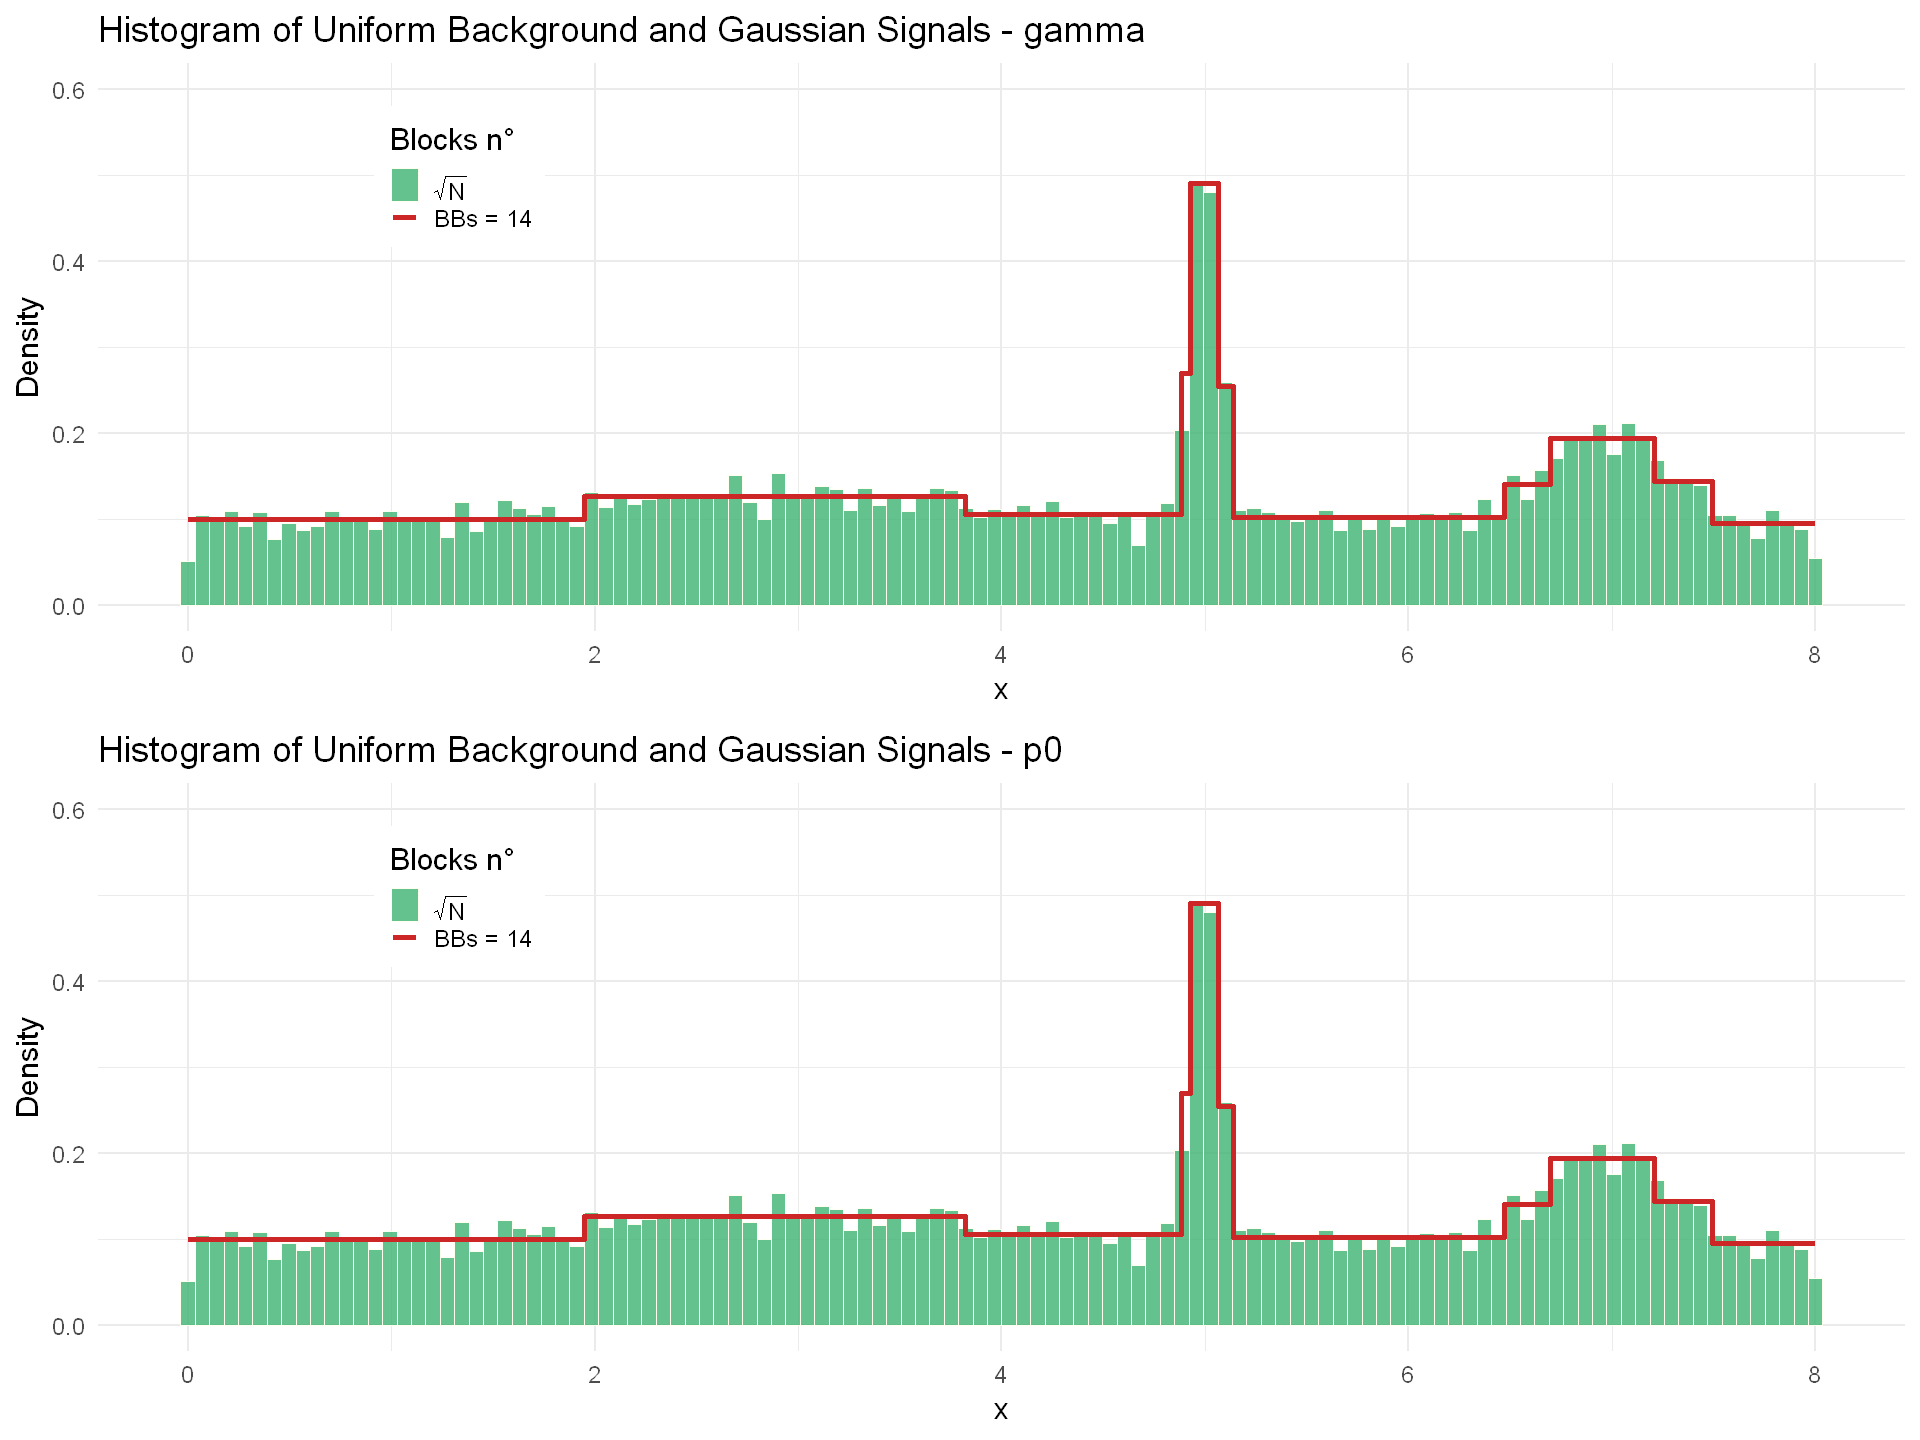

In [28]:
ggsave('../images/test_noise.png', plot=noise_plot, width = 16, height = 12)

### 2.3 ECG Data

In [30]:
ecg_data <- read.csv2('../data/ecg.csv') 
ecg_data <- ecg_data[1:1000,]

In [33]:
edges_ecg <- bayesian_blocks(t=ecg_data$ms, x=ecg_data$heartrate, data_type = 'PointMeasures', ncp_prior = 100)

N_edges_ecg <- length(edges_ecg)

#counting mean over edges
steps_ecg = rep(0, N_edges_ecg)

for (K in seq(1:N_edges_ecg)){
    steps_ecg[K] = mean(ecg_data$heartrate[ecg_data$ms>=edges_ecg[K] & ecg_data$ms<=edges_ecg[K+1]])
    if (K==N_edges_ecg-1){break}
}
steps_ecg[length(edges_ecg)] = steps_ecg[length(edges_ecg)-1]

In [34]:
ecg_plot = ggplot() +
    geom_line(aes(x = ecg_data$ms, y=ecg_data$heartrate), color='navy', linewidth=1)+
    theme_minimal(base_size = 18) + 
    xlim(0, 1200)+
    labs(x='Time [ms]', y=TeX('ECG $[mu V]$'), title="ECG plot")

bb_ecg_plot = ggplot()+
    geom_line(aes(x = ecg_data$ms, y=ecg_data$heartrate, color=as.factor(1)), linewidth=1)+
    geom_step(aes(x=edges_ecg, y=steps_ecg, colour=as.factor(2)), linewidth=1.2)+    
    scale_colour_manual(name = "Color", labels = c('ECG', 'BBs'),
                        values = c('navy', 'firebrick2')) +
    theme_minimal(base_size = 18) + 
    theme(legend.position = c(0.2, 0.8), legend.background = element_rect(fill = "white", color='white')) +
    xlim(0, 1200)+
    labs(x='Time [ms]', y=TeX('ECG $[mu V]$'), title="ECG's BBs representation")

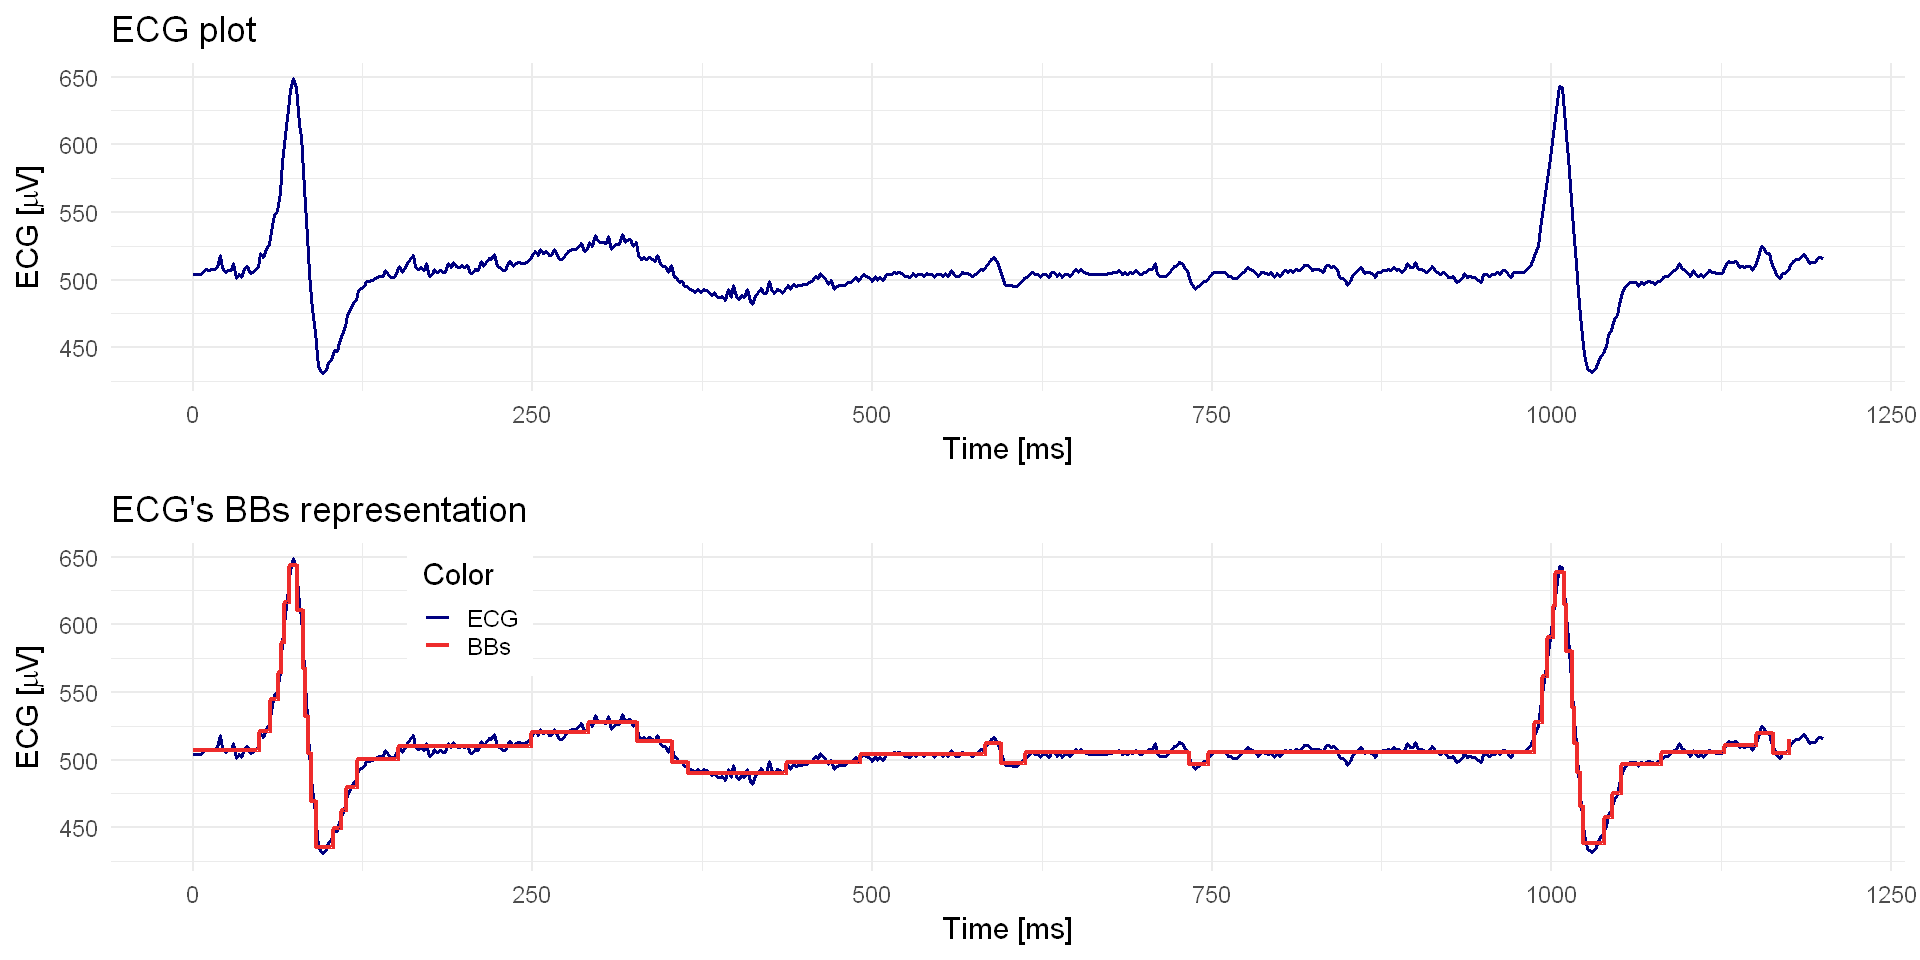

In [37]:
options(repr.plot.width = 16, repr.plot.height=8)
layout <- matrix(c(1,2,1,2), ncol=2, byrow=F)
ecg_grid <- grid.arrange(ecg_plot, bb_ecg_plot, layout_matrix=layout)

In [38]:
ggsave('../images/ecg_plot.png', plot=ecg_grid, width = 16, height = 8)

## 3. KDE vs Bayesian Bloks

In [39]:
test_dist = c(runif(5000, min=0, max=100), rnorm(700, mean=10, sd=4 ), rnorm(700, mean=40, sd=1 ))
counts = rep(1, 6400)
x_lin = seq(0, 100, length.out = 10000)

density = dunif(x_lin, min=0, max=100) + dnorm(x_lin, mean=10, sd=4 ) + dnorm(x_lin, mean=40, sd=1 )
density = density/sum(density*0.01)

edges = bayesian_blocks(test_dist)
N_edges = length(edges)

steps = rep(0, N_edges)

for (K in seq(1: N_edges)){    
    steps[K] = sum(counts[test_dist>=edges[K] & test_dist<edges[K+1]])/sum(counts*(edges[K+1] - edges[K]))    
    if (K==N_edges-1){break}
}

steps[N_edges] = steps[N_edges-1]

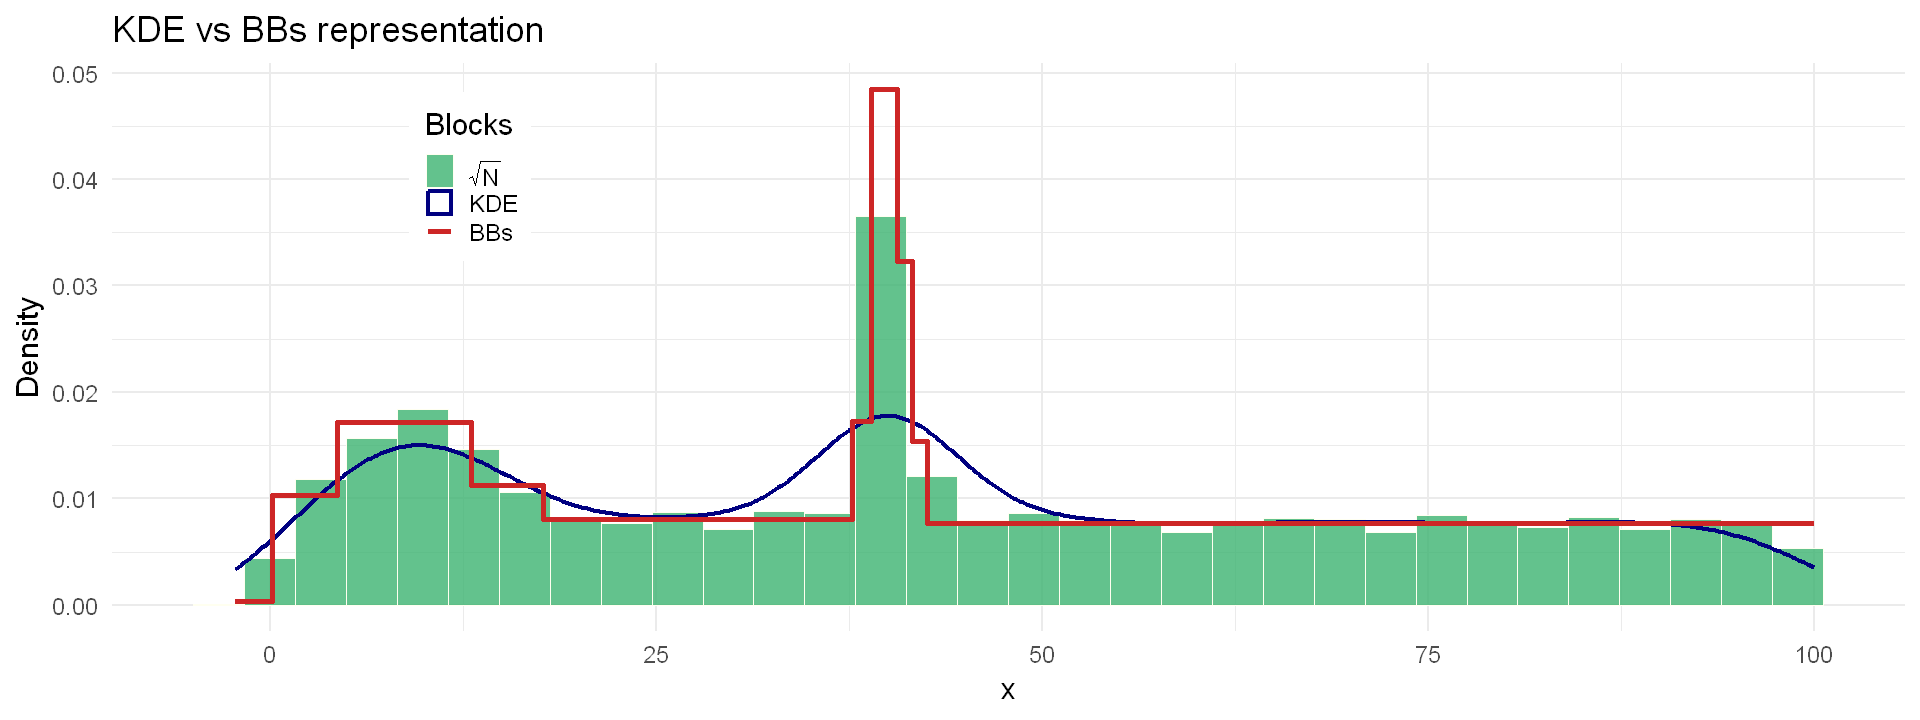

In [42]:
options(repr.plot.width=16, repr.plot.height=6)

kde_bb_plot <- ggplot()+
    geom_histogram(aes(x=test_dist, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), bins = 32, alpha = 0.8) +
    geom_density(aes(test_dist, ,color=as.factor(2), fill=as.factor(2)), linewidth=1.2, alpha=0) +
    geom_step(aes(x=edges, y=steps, color=as.factor(3), fill=as.factor(3)), linewidth=1.6) + 
    theme_minimal(base_size = 18) + 
    theme(legend.position = c(0.2, 0.8), legend.background = element_rect(fill = "white", color='white')) +
    scale_fill_manual(name = 'Blocks', labels = c(TeX(r'($\sqrt{N}$)'), 'KDE', 'BBs'), 
                      values = c('mediumseagreen', 'navy', 'firebrick3')) + 
    scale_colour_manual(name = 'Blocks', labels = c(TeX(r'($\sqrt{N}$)'), 'KDE', 'BBs'),
                      values = c('ivory', 'navy', 'firebrick3'))+
    labs(x='x', y='Density', title='KDE vs BBs representation')

kde_bb_plot

In [43]:
ggsave('../images/kde_vs_bb.png', plot=kde_bb_plot, width = 16, height = 6)